In [1]:
import pandas as pd
from env import host, username, password
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wrangle
from scipy import stats

In [2]:
# Call the function to get the Zillow data
zillow_df = wrangle.get_zillow_data()

# Write dataframe to CSV file
zillow_df.to_csv("zillow_data.csv", index=False)

In [3]:
df = wrangle.read_csv_file()

In [4]:
prep_df = wrangle.handle_missing_values(df, .60, .75)

In [5]:
prep_df.head()

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate,logerror
0,1727539,14297519,3.5,4.0,NaN,3.5,3100.0,3100.0,6059.0,3.0,...,NaN,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,2017-01-01,0.025595
1,1387261,17052889,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,1.0,...,NaN,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,2017-01-01,0.055619
2,11677,14186244,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,2.0,...,NaN,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,2017-01-01,0.005383
3,2288172,12177905,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,...,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,2017-01-01,-0.103410
4,1970746,10887214,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,...,1.0,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,2017-01-01,0.006940


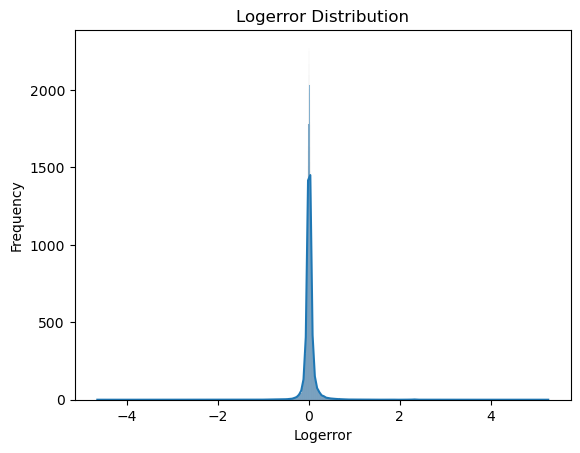

In [6]:
from scipy import stats
#1. How is logerror distributed?
sns.histplot(data=prep_df, x='logerror', kde=True)
plt.title('Logerror Distribution')
plt.xlabel('Logerror')
plt.ylabel('Frequency')
plt.show()

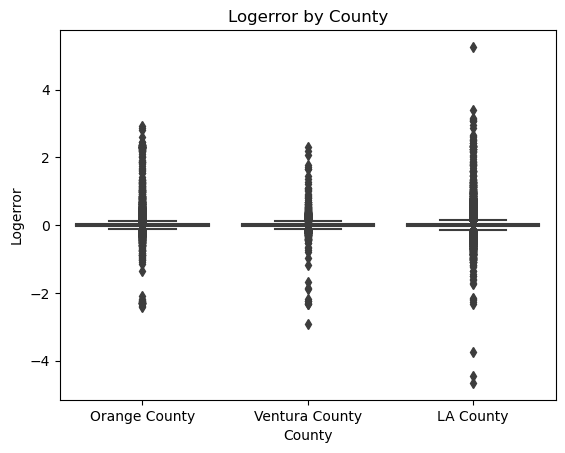

F-statistic: 10.345389144223091
p-value: 3.218707953568957e-05


In [7]:
#2. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?
# FIPS codes: LA County (6037), Orange County (6059), Ventura County (6111)
county_names = {6037: 'LA County', 6059: 'Orange County', 6111: 'Ventura County'}

prep_df['county_name'] = prep_df['fips'].map(county_names)

sns.boxplot(data=prep_df, x='county_name', y='logerror')
plt.title('Logerror by County')
plt.xlabel('County')
plt.ylabel('Logerror')
plt.show()

# Perform ANOVA test
F, p = stats.f_oneway(prep_df[prep_df['county_name'] == 'LA County']['logerror'],
                      prep_df[prep_df['county_name'] == 'Orange County']['logerror'],
                      prep_df[prep_df['county_name'] == 'Ventura County']['logerror'])

print("F-statistic:", F)
print("p-value:", p)

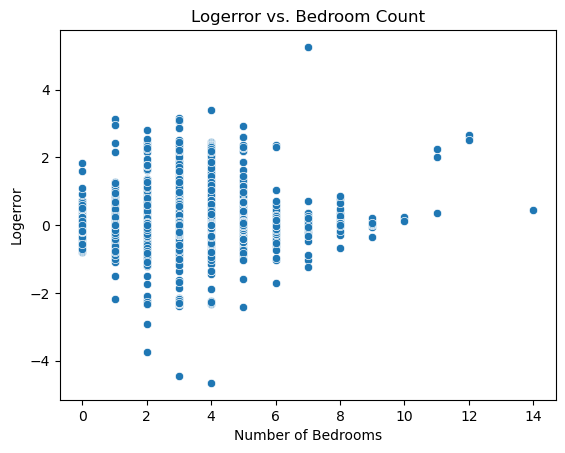

In [8]:
#3. Is there a relationship between the number of bedrooms and logerror?
sns.scatterplot(data=prep_df, x='bedroomcnt', y='logerror')
plt.title('Logerror vs. Bedroom Count')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Logerror')
plt.show()

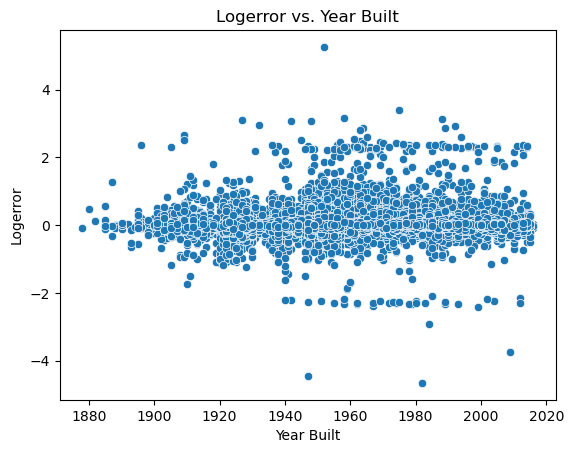

In [9]:
#4. Is there a relationship between the year built and logerror?
sns.scatterplot(data=prep_df, x='yearbuilt', y='logerror')
plt.title('Logerror vs. Year Built')
plt.xlabel('Year Built')
plt.ylabel('Logerror')
plt.show()

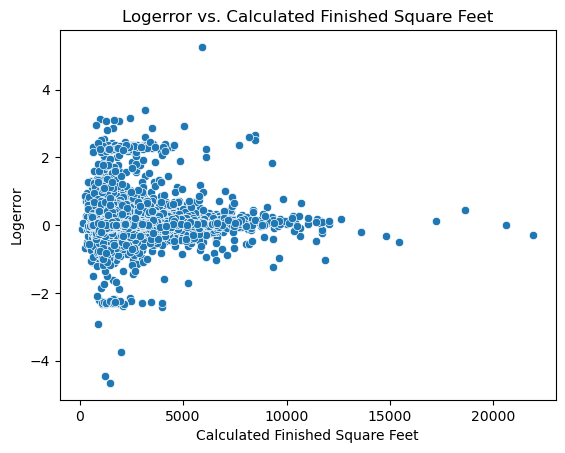

In [10]:
#5. Is there a relationship between the calculated finished square feet and logerror?
sns.scatterplot(data=prep_df, x='calculatedfinishedsquarefeet', y='logerror')
plt.title('Logerror vs. Calculated Finished Square Feet')
plt.xlabel('Calculated Finished Square Feet')
plt.ylabel('Logerror')
plt.show()

#Bonus
_________________

In [11]:
mean_by_zipcode = prep_df.groupby('regionidzip')['logerror'].mean()
overall_mean = prep_df['logerror'].mean()

print("Mean logerror by zipcode:\n", mean_by_zipcode)
print("\nOverall mean logerror:", overall_mean)

Mean logerror by zipcode:
 regionidzip
95982.0     0.007129
95983.0     0.005477
95984.0    -0.076873
95985.0     0.033332
95986.0     0.041537
              ...   
97329.0     0.018071
97330.0     0.013530
97331.0     0.045914
97344.0     0.025212
399675.0   -0.025808
Name: logerror, Length: 388, dtype: float64

Overall mean logerror: 0.01669622920285324


In [12]:
significant_zipcodes = []

for zipcode, zipcode_mean in mean_by_zipcode.items():
    t_stat, p_value = stats.ttest_1samp(prep_df[prep_df['regionidzip'] == zipcode]['logerror'], overall_mean)
    
    if p_value < 0.05:  # Using a significance level of 0.05
        significant_zipcodes.append((zipcode, zipcode_mean, p_value))

# Sort the significant zipcodes by logerror
significant_zipcodes.sort(key=lambda x: x[1])

print("Significant zip codes where the error is significantly higher or lower than the expected error:")
for zipcode, zipcode_mean, p_value in significant_zipcodes:
    print(f"Zipcode: {zipcode}, Mean logerror: {zipcode_mean}, p-value: {p_value}")

Significant zip codes where the error is significantly higher or lower than the expected error:
Zipcode: 96019.0, Mean logerror: -0.10126944757109914, p-value: 0.04902934465864106
Zipcode: 95984.0, Mean logerror: -0.07687250584990266, p-value: 0.0016692179671312214
Zipcode: 96043.0, Mean logerror: -0.07396374659926705, p-value: 0.0009796455011905469
Zipcode: 96097.0, Mean logerror: -0.042394954974837314, p-value: 0.0007397278173481806
Zipcode: 96137.0, Mean logerror: -0.04049703690015724, p-value: 1.1757806847980997e-05
Zipcode: 96280.0, Mean logerror: -0.039544041374380966, p-value: 0.00025936296388340025
Zipcode: 96020.0, Mean logerror: -0.03340015621864021, p-value: 0.00028988390580243447
Zipcode: 96007.0, Mean logerror: -0.03319173230337948, p-value: 0.0006107041741874219
Zipcode: 96047.0, Mean logerror: -0.026702169516557357, p-value: 1.3669175216560578e-05
Zipcode: 95989.0, Mean logerror: -0.024971966238463723, p-value: 0.000308510395206852
Zipcode: 96326.0, Mean logerror: -0.024